In [4]:
import data_importer
import model as md
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

float64 float64 (1, 480, 640, 3) (1, 480, 640)


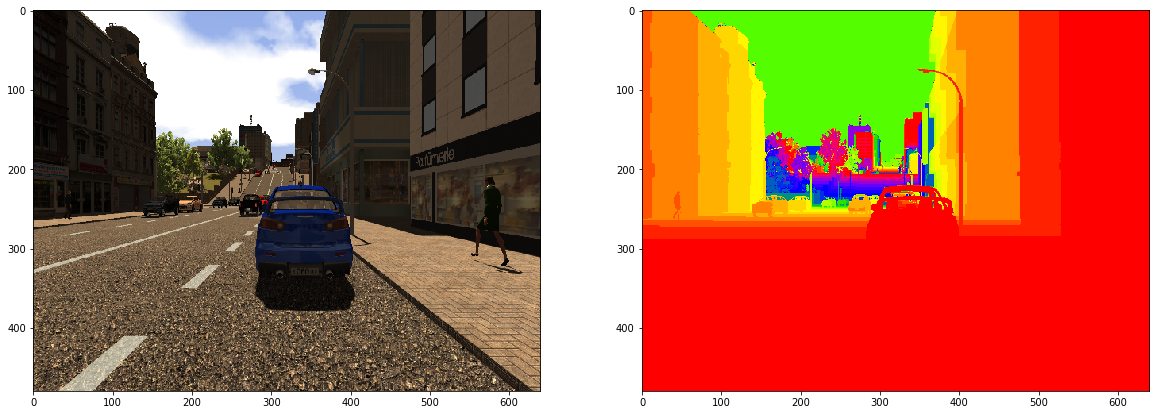

In [5]:
SYNTHIA = data_importer.SynthiaSf('D:/Library/Datasets/SYNTHIA-SF/',label_type='depth',shuffle=True, repeater=True)
preview = iter(SYNTHIA)

a,b=next(preview)
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(a[0])
plt.subplot(1,2,2)
plt.imshow(b[0])
plt.prism()

print(a.dtype, b.dtype, a.shape, b.shape)

float64 uint8 (1, 480, 640, 3) (1, 480, 640, 1)


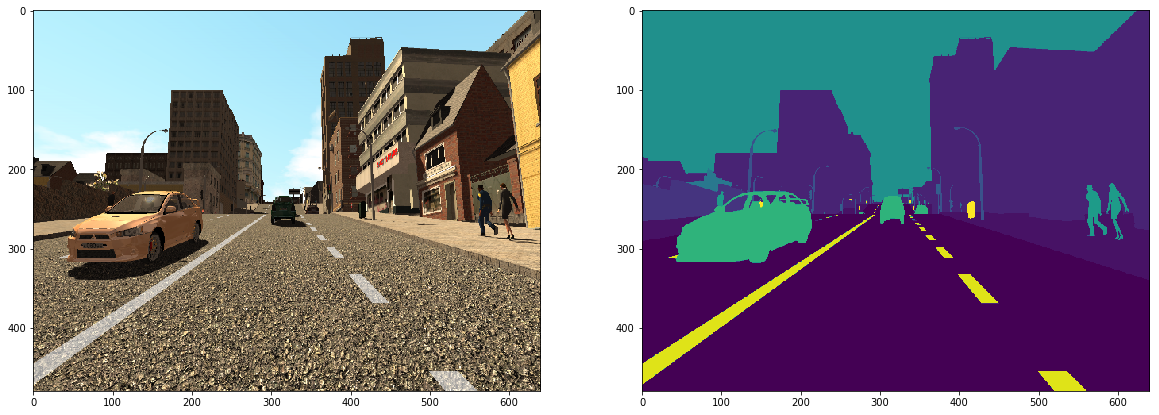

In [6]:
SYNTHIA = data_importer.SynthiaSf('D:/Library/Datasets/SYNTHIA-SF/',label_type='sparse_segmentation',shuffle=True, repeater=True)
preview = iter(SYNTHIA)

a,b=next(preview)
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(a[0])
plt.subplot(1,2,2)
plt.imshow(b[0,:,:,0])
plt.viridis()

print(a.dtype, b.dtype, a.shape, b.shape)

In [7]:
img_shape = (480, 640, 3)

In [8]:
layers = tf.keras.layers
losses = tf.keras.losses

In [9]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [10]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(22, (1, 1), activation='softmax')(decoder0)

# outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# # pre_outputs = layers.Conv2D(1, (1, 1), activation='softmax')(decoder0)
# # pre_outputs = layers.D(1, (1, 1), activation='softmax')(decoder0)

In [11]:
model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [8]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [9]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [10]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [11]:
def loss(y_true, y_pred):
    return tf.keras.backend.sparse_categorical_crossentropy(target=y_true, output=y_pred, from_logits=True)

In [15]:
model=tf.keras.utils.multi_gpu_model(model, gpus=2)

ValueError: To call `multi_gpu_model` with `gpus=2`, we expect the following devices to be available: ['/cpu:0', '/gpu:0', '/gpu:1']. However this machine only has: ['/cpu:0', '/gpu:0']. Try reducing `gpus`.

In [12]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy"])
# model.summary()

In [15]:
save_model_path = './log/unet/1/'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path + 'weights.hdf5', save_best_only=True),
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=10),#restore_best_weights=True
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir=save_model_path)
]

In [16]:
history = model.fit_generator(SYNTHIA, 
                   steps_per_epoch=preview.dataset.shape[0] - 1,
                   epochs=1,
                   callbacks=callbacks)

Epoch 1/1
  48/4447 [..............................] - ETA: 2:50:59 - loss: 1.7706 - sparse_categorical_crossentropy: 1.7706

KeyboardInterrupt: 

In [14]:
model = tf.keras.models.load_model('C:/Users/mamin/GitHub/DeepLabV3plus/log/1/weights.hdf5')

In [15]:
a,b=next(preview)
model.evaluate(a,b)

1/1 [==============================] - 1s 1s/step


[0.3836826980113983, 0.3836826980113983]

In [16]:
a,b=next(preview)
c=model.predict(a,steps=1)

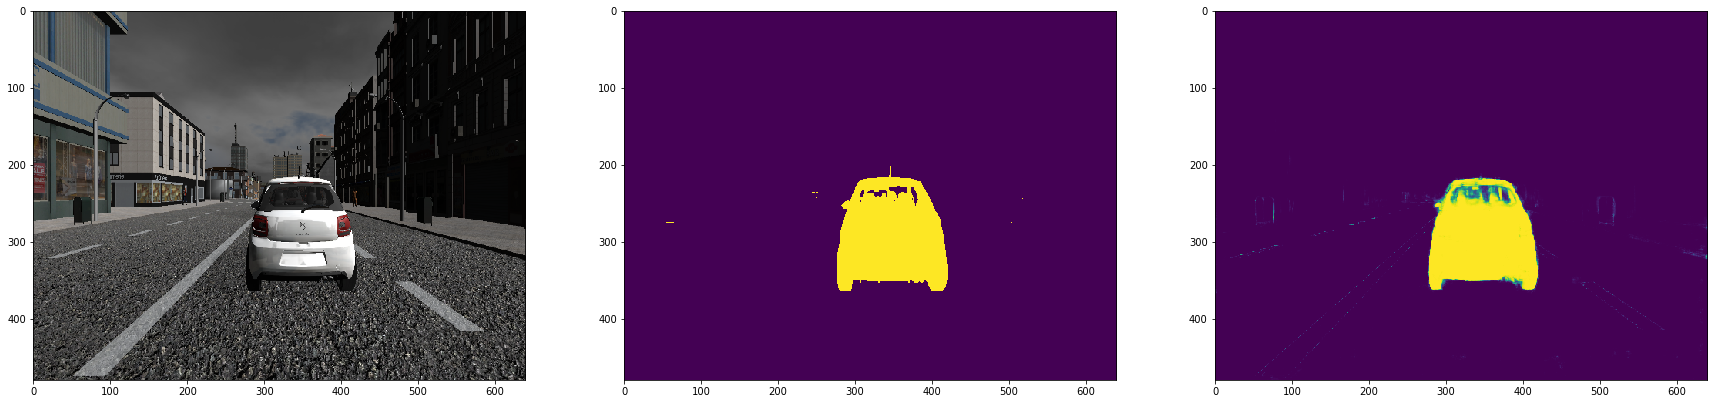

In [12]:
i=14
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(b[0,:,:,0]==i)
plt.subplot(1,3,3)
plt.imshow(c[0,:,:,i])

In [41]:
import skimage
address = "D:/Library/Datasets/(GTA-V)Playing for Benchmarks/train/img/004/004_00071.jpg"
address_inst = "D:/Library/Datasets/(GTA-V)Playing for Benchmarks/train/cls/004/004_00071.png"
address2 = "D:/Library/Datasets/kiti/data_semantics/training/image_2/000147_10.png"
address2_inst = "D:/Library/Datasets/kiti/data_semantics/training/semantic/000147_10.png"
address3 = "D:/Library/Datasets/kiti/data_semantics/training/image_2/000127_10.png"
address3_inst = "D:/Library/Datasets/kiti/data_semantics/training/semantic/000127_10.png"


a=skimage.transform.resize(image=skimage.io.imread(address2),
            output_shape=(480, 640))
b=skimage.img_as_ubyte(skimage.transform.resize(image=skimage.io.imread(address2_inst),
            output_shape=(480, 640)))
a = np.reshape(a,(1,480,640,3))

In [42]:
c=model.predict(a,steps=1)

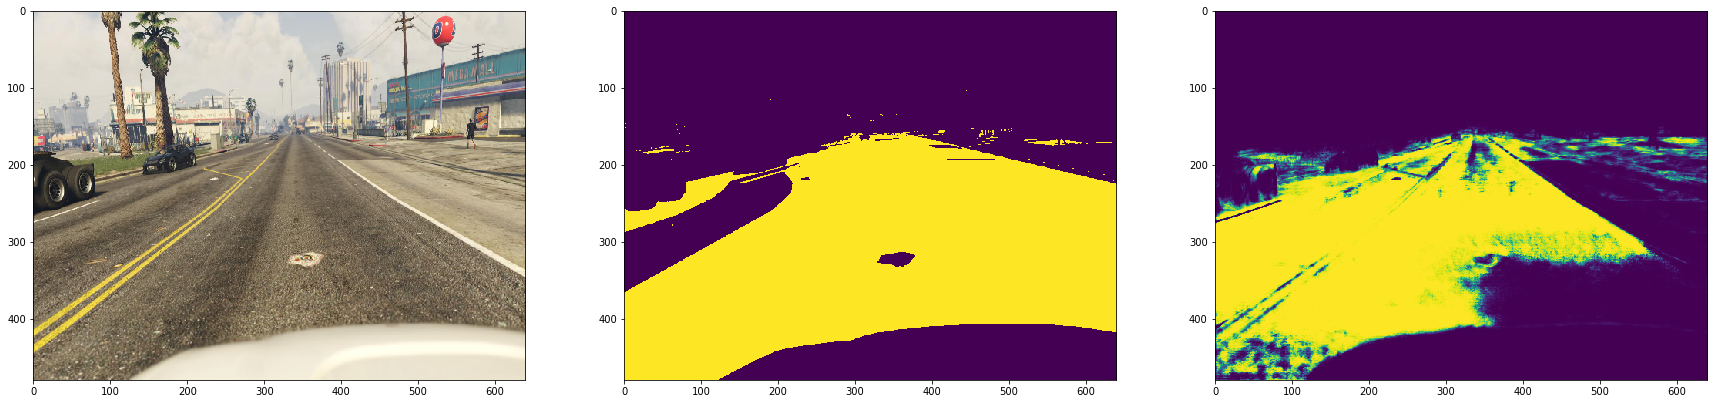

In [107]:
i=1
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(b[:,:,0]==128)
plt.subplot(1,3,3)
plt.imshow(c[0,:,:,i])

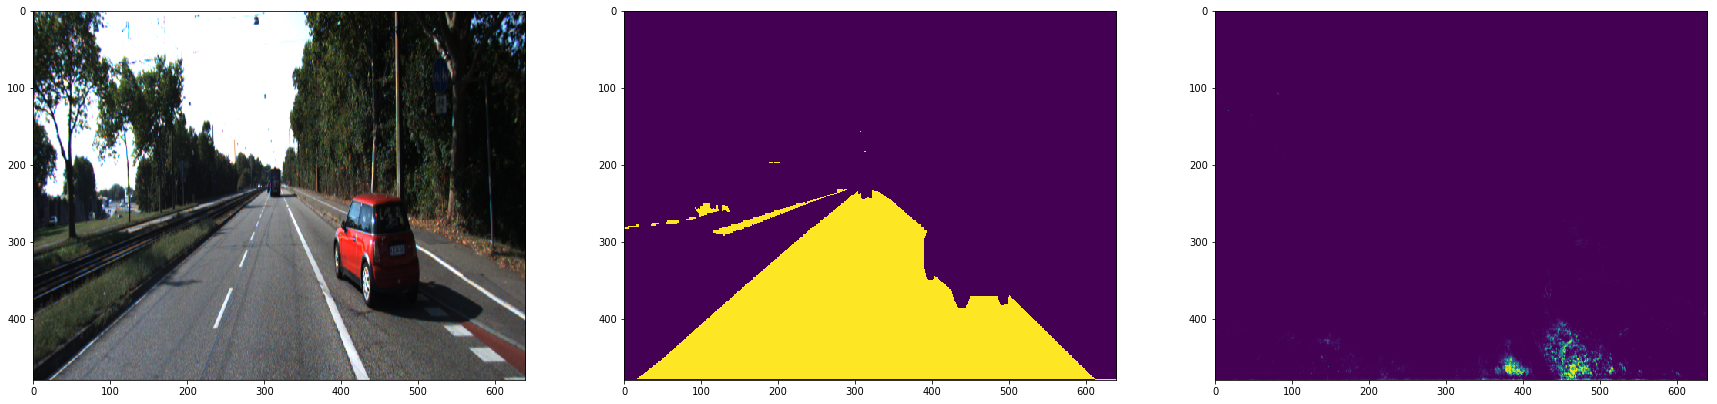

In [44]:
i=1
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(b[:,:]==7)
plt.subplot(1,3,3)
plt.imshow(c[0,:,:,i])

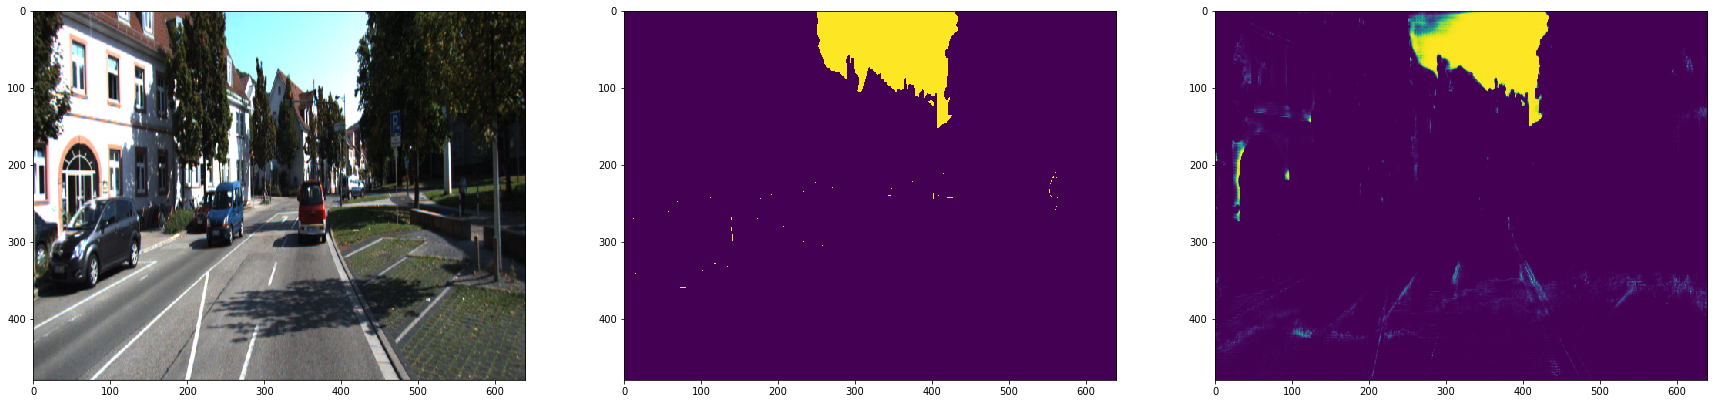

In [39]:
i=11
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(b[:,:]==23)
plt.subplot(1,3,3)
plt.imshow(c[0,:,:,i])

In [12]:
import numpy as np
import skimage
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
address = "D:/Library/Datasets/(GTA-V)Playing for Benchmarks/train/img/004/004_00071.jpg"
address2= "D:/Library/Datasets/kiti/data_semantics/training/image_2/000000_10.png"
address3= "D:/Library/Datasets/SYNTHIA-SF/SEQ1/RGBLeft/0000000.png"
# a=skimage.transform.resize(image=imageio.imread(address),
#             output_shape=(480, 640))
# a = np.reshape(a,(1,480,640,3))

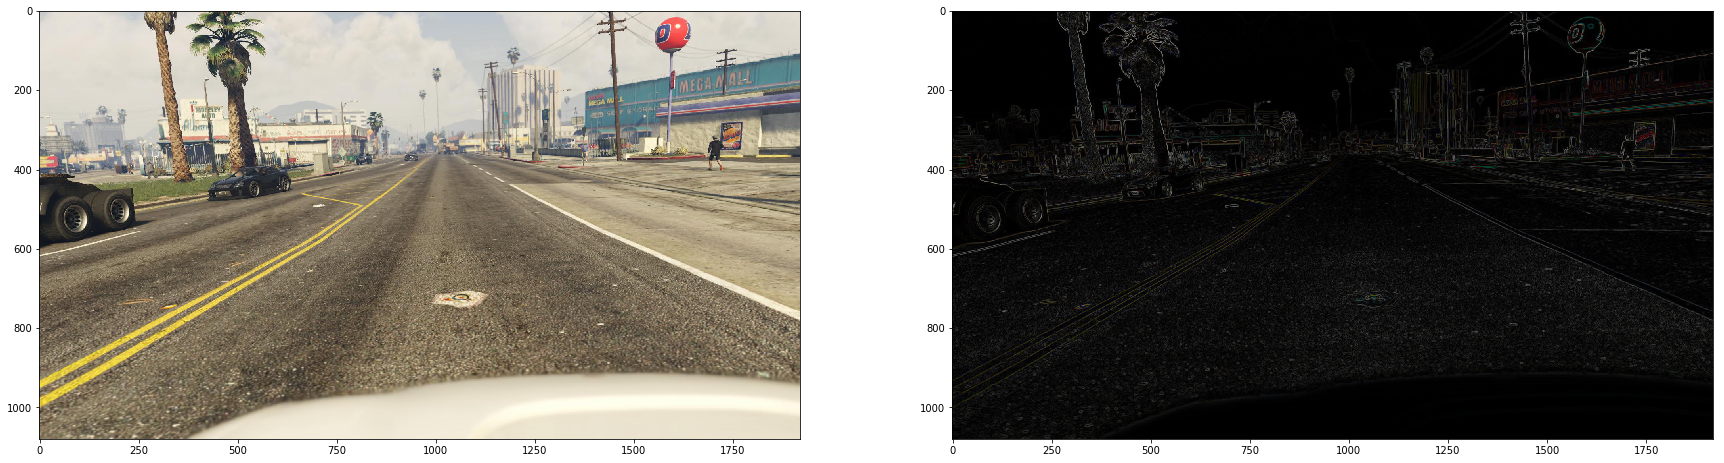

In [18]:
a = imread(address)/256.0
a = np.reshape(a,(1,1080,1920,3))
aa= np.ndarray(shape=a.shape)

aa[0,:,:,0] = skimage.filters.sobel(a[0,:,:,0])
aa[0,:,:,1] = skimage.filters.sobel(a[0,:,:,1])
aa[0,:,:,2] = skimage.filters.sobel(a[0,:,:,2])

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(a[0,:,:])
plt.subplot(1,2,2)
plt.imshow(aa[0,:,:])

In [125]:
dataset_dir = "D:/Library/Datasets/(GTA-V)Playing for Benchmarks"

img_dir_list = [dataset_dir + '/train' + '/img' + '/' + seq_dir + '/' + img_name 
                for seq_dir in os.listdir(dataset_dir + '/train/' + '/img/' )
                for img_name in os.listdir(dataset_dir + '/train/' + '/img/' + seq_dir)]

cls_dir_list = [dataset_dir + '/train' + '/cls' + '/' + seq_dir + '/' + img_name 
                for seq_dir in os.listdir(dataset_dir + '/train/' + '/cls/' )
                for img_name in os.listdir(dataset_dir + '/train/' + '/cls/' + seq_dir)]

inst_dir_list = [dataset_dir + '/train' + '/inst' + '/' + seq_dir + '/' + img_name 
                for seq_dir in os.listdir(dataset_dir + '/train/' + '/inst/' )
                for img_name in os.listdir(dataset_dir + '/train/' + '/inst/' + seq_dir)]